In [1]:
import argparse
import os

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.utils as vutils

In [2]:
img_size = 32
channels = 1
latent_dim = 100
batch_size = 128
n_epochs = 1000

cuda = True if torch.cuda.is_available() else False

## 2015 - Deep Convolutional GAN (DCGAN)

In [ ]:
lr, beta1, beta2 = 2e-4, 0.5, 0.999
D_steps = 1

In [ ]:
# Configure data loader
transform = transforms.Compose([
    transforms.Resize(img_size), 
    transforms.ToTensor(), 
    transforms.Normalize([0.5], [0.5]),
])
train_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform,
)
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              drop_last=True)
test_dataset = datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.linear = nn.Linear(100, 128 * 8 * 8)
        self.upconv1 = nn.Sequential(
            nn.BatchNorm2d(128),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.upconv2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.upconv3 = nn.Sequential(
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        z = self.linear(z)
        z = z.view(-1, 128, 8, 8)
        z = self.upconv1(z)
        z = self.upconv2(z)
        z = self.upconv3(z)
        return z

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(channels, 16, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(32, 0.8),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(64, 0.8),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(128, 0.8),
        )
        ds_size = img_size // 2 ** 4
        self.linear = nn.Sequential(
            nn.Linear(128 * ds_size ** 2, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(batch_size, -1)
        x = self.linear(x)
        return x

In [ ]:
# Loss function
loss = nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
fixed_noise = Variable(Tensor(np.random.normal(0, 1, (8, latent_dim))))

[Epoch 0/100] [Iteration 468] [D loss: 1.393061] [G loss: 0.692531]


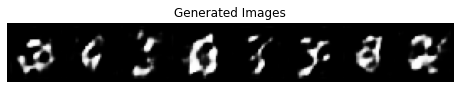

[Epoch 10/100] [Iteration 5148] [D loss: 1.238224] [G loss: 0.823666]


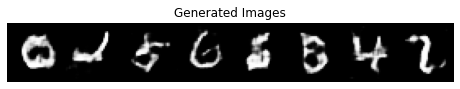

[Epoch 20/100] [Iteration 9828] [D loss: 1.219268] [G loss: 1.085316]


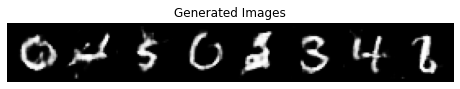

[Epoch 30/100] [Iteration 14508] [D loss: 1.262532] [G loss: 0.897498]


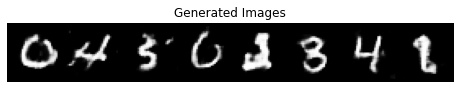

[Epoch 40/100] [Iteration 19188] [D loss: 1.266668] [G loss: 1.894146]


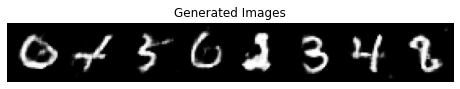

[Epoch 50/100] [Iteration 23868] [D loss: 0.696789] [G loss: 0.612143]


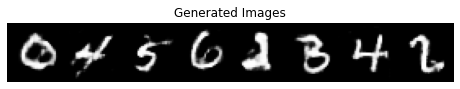

[Epoch 60/100] [Iteration 28548] [D loss: 0.953874] [G loss: 1.012269]


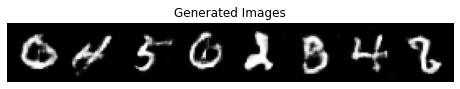

[Epoch 70/100] [Iteration 33228] [D loss: 0.945790] [G loss: 1.776042]


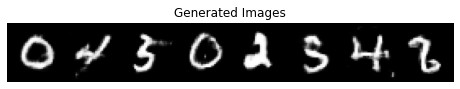

[Epoch 80/100] [Iteration 37908] [D loss: 0.497383] [G loss: 0.597499]


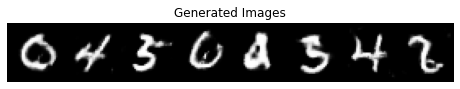

[Epoch 90/100] [Iteration 42588] [D loss: 0.435313] [G loss: 0.929219]


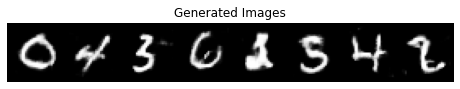

In [ ]:
#!rm ./*.png

g_losses, d_losses = [], []

total_it = 0
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_dataloader):

        for _ in range(D_steps):
            # Update discriminator
            optimizer_D.zero_grad()
            # 1. Sample (x1, ..., xm) from p_data (data distribution)
            real_imgs = Variable(imgs.type(Tensor))
            # 2. Sample (z1, ..., zm) from p_z (noise distribution)
            z = Variable(Tensor(np.random.normal(0, 1, (batch_size, latent_dim))))
            # 3. Generate fake images from the noise vectors: (G(z1), ..., G(zm))
            gen_imgs = generator(z)
            # 4. Compute the (least-squares) discriminator loss
            d_real = discriminator(real_imgs)
            d_fake = discriminator(gen_imgs.detach())
            d_loss = - torch.mean(torch.log(d_real) + torch.log(1. - d_fake))
            # 5. Update the parameters of the discriminator
            d_loss.backward()
            optimizer_D.step()

        # Update the generator
        optimizer_G.zero_grad()
        # 1. Sample new (z1, ..., zm) from p_z (noise distribution)
        z = Variable(Tensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        # 2. Generate fake images from the noise vectors: (G(z1), ..., G(zm))
        gen_imgs = generator(z)
        # 3. Compute the (least-squares) generator loss
        d_fake = discriminator(gen_imgs)
        g_loss = - torch.mean(torch.log(d_fake))
        # 4. Update the parameters of the generator
        g_loss.backward()
        optimizer_G.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
    
        total_it += 1
    
    if epoch % 10 == 0:
        print(
            '[Epoch %d/%d] [Iteration %d] [D loss: %f] [G loss: %f]'
            % (epoch, n_epochs, total_it, d_loss.item(), g_loss.item())
        )
        img_list = []
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(np.transpose(img_list[-1].cpu(), (1, 2, 0)))
        plt.show()

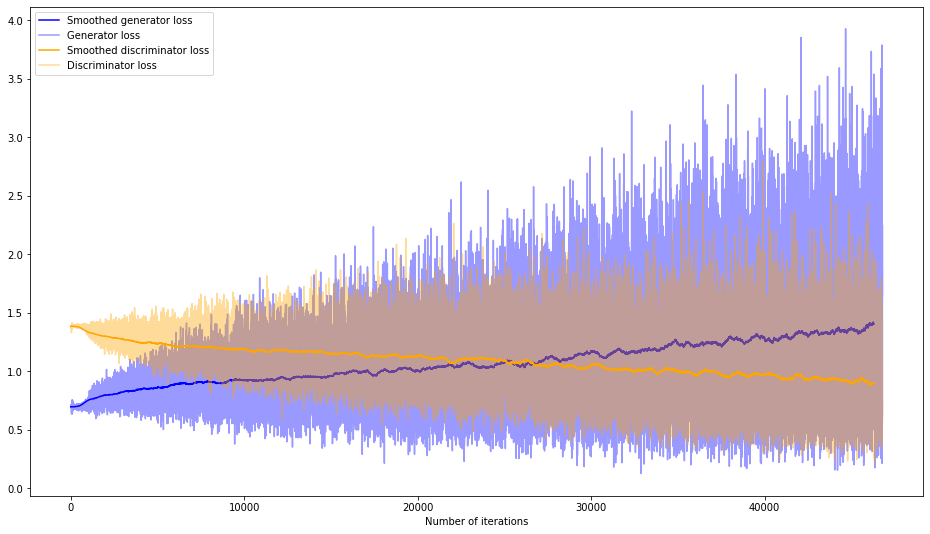

In [ ]:
window_width = 500

tmp = np.cumsum(g_losses)
smooth_g_losses = (tmp[window_width:] - tmp[:-window_width]) / window_width
tmp = np.cumsum(d_losses)
smooth_d_losses = (tmp[window_width:] - tmp[:-window_width]) / window_width

plt.figure(figsize=(16, 9))
plt.plot(smooth_g_losses, label='Smoothed generator loss', alpha=1., c='blue')
plt.plot(g_losses, label='Generator loss', alpha=.4, c='blue')
plt.plot(smooth_d_losses, label='Smoothed discriminator loss', alpha=1., c='orange')
plt.plot(d_losses, label='Discriminator loss', alpha=.4, c='orange')
plt.xlabel('Number of iterations')
plt.legend()
plt.show()

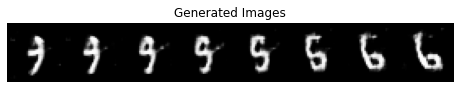

In [ ]:
z1 = np.random.normal(0, 1, (1, latent_dim))[0]
z2 = np.random.normal(0, 1, (1, latent_dim))[0]

alphas = np.linspace(0., 1., 8)
interpolations = [alpha * z1 + (1. - alpha) * z2 for alpha in alphas]
interpolations = np.array(interpolations)
interpolations = Variable(Tensor(interpolations))

img_list = []
with torch.no_grad():
    fake = generator(interpolations).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_list[-1].cpu(), (1, 2, 0)))
plt.show()

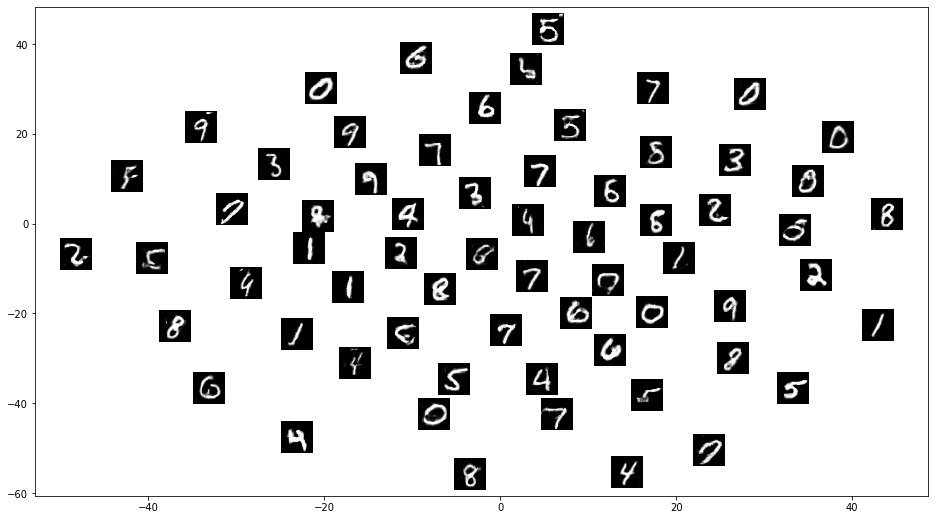

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
numpy_noise = np.random.normal(0, 1, (64, latent_dim))
tensor_noise = Variable(Tensor(numpy_noise))

img_list = []
with torch.no_grad():
    fake = generator(tensor_noise).detach().cpu().numpy()

X_embedded = TSNE(n_components=2).fit_transform(numpy_noise)
x, y = X_embedded[:,0], X_embedded[:,1]

fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(x, y)
for i, (x0, y0) in enumerate(zip(x, y)):
    ab = AnnotationBbox(OffsetImage(fake[i][0,:,:], cmap="gray"), (x0, y0), frameon=False)
    ax.add_artist(ab)
plt.show()

## 2017 - CycleGAN

In [ ]:
lr, beta1, beta2 = 2e-4, .5, .999
lambda_cycle = 10

In [ ]:
class UnpairedImageDataset(torch.utils.data.Dataset):
    def __init__(self, source, target):
        self.source = source
        self.target = target
    def __getitem__(self, idx):
        image_X = self.source[idx][0]
        image_Y = self.target[idx][0]
        return {'X': image_X, 'Y': image_Y}
    def __len__(self):
        return min(len(self.source), len(self.target))

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=1),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=1),
            nn.InstanceNorm2d(in_features),
        )
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, channels_in=1, channels_out=1, num_residual_blocks=1):
        super(Generator, self).__init__()

        self.encoder = nn.Sequential(
            # conv1
            nn.Conv2d(channels_in, 32, 3, stride=2, padding=1),
            nn.InstanceNorm2d(32),
            nn.ReLU(inplace=True),
            # conv2
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        )

        residual_blocks = [ResidualBlock(64) for _ in range(num_residual_blocks)]
        self.transformer = nn.Sequential(*residual_blocks)

        self.decoder = nn.Sequential(
            # upconv1
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            # upconv2
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, channels_out, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.transformer(x)
        x = self.decoder(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, channels_in=1):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels_in, 16, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(32, 0.8),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(64, 0.8),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(128, 0.8),
        )
        ds_size = img_size // 2 ** 4
        self.linear = nn.Sequential(
            nn.Linear(128 * ds_size ** 2, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(batch_size, -1)
        x = self.linear(x)
        return x

In [ ]:
# Configure data loader
source_tf = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])
target_tf = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Normalize([0.5], [0.5]),
])

source_train = datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=source_tf,
)
source_test = datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=source_tf,
)

target_train = datasets.USPS(
    root='./data', 
    train=True,
    download=True, 
    transform=target_tf,
)
target_test = datasets.USPS(
    root='./data', 
    train=False, 
    download=True, 
    transform=target_tf
)

train_dataset = UnpairedImageDataset(source_train, target_train)
test_dataset = UnpairedImageDataset(source_test, target_test)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    drop_last=True
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    drop_last=True
)

In [ ]:
# Loss functions
#MSE_loss = nn.MSELoss() #nn.BCELoss()
#L1_loss = nn.L1Loss()

# Generators and Discriminators
G_XY = Generator(channels_in=1, channels_out=1)
G_YX = Generator(channels_in=1, channels_out=1)
D_X = Discriminator(channels_in=1)
D_Y = Discriminator(channels_in=1)

if cuda:
    G_XY = G_XY.cuda()
    G_YX = G_YX.cuda()
    D_X = D_X.cuda()
    D_Y = D_Y.cuda()
    #MSE_loss.cuda()
    #L1_loss.cuda()

# Initialize weights
G_XY.apply(weights_init_normal)
G_YX.apply(weights_init_normal)
D_X.apply(weights_init_normal)
D_Y.apply(weights_init_normal)

# Optimizers
optimizer_G_XY = torch.optim.Adam(G_XY.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_G_YX = torch.optim.Adam(G_YX.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D_X = torch.optim.Adam(D_X.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D_Y = torch.optim.Adam(D_Y.parameters(), lr=lr, betas=(beta1, beta2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
def sample_images():
    """Saves a generated sample from the test set"""
    imgs = next(iter(test_dataloader))
    G_XY.eval()
    G_YX.eval()
    real_X = Variable(imgs["X"].type(Tensor))
    real_Y = Variable(imgs["Y"].type(Tensor))
    fake_X = G_YX(real_Y)
    fake_Y = G_XY(real_X)
    # Arange images along x-axis
    real_X = vutils.make_grid(real_X, nrow=5, normalize=True)
    real_Y = vutils.make_grid(real_Y, nrow=5, normalize=True)
    fake_X = vutils.make_grid(fake_X, nrow=5, normalize=True)
    fake_Y = vutils.make_grid(fake_Y, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_X, fake_Y, real_Y, fake_X), 1)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(image_grid.cpu(), (1, 2, 0)))
    plt.show()

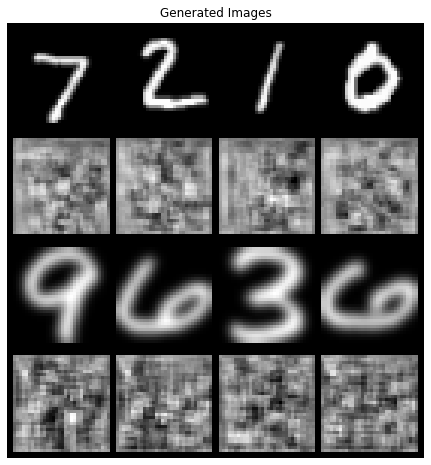

In [ ]:
sample_images()

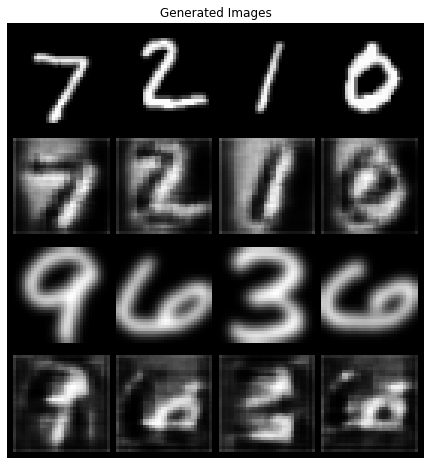

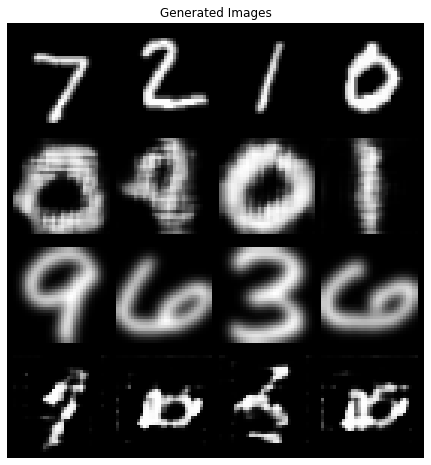

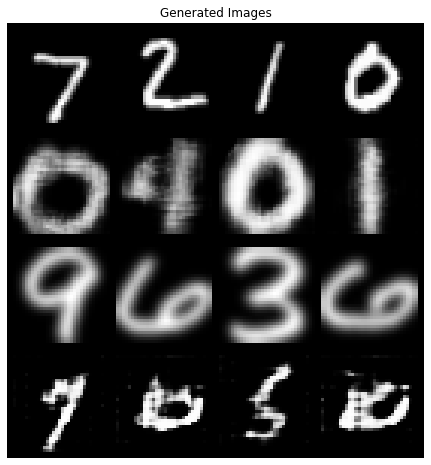

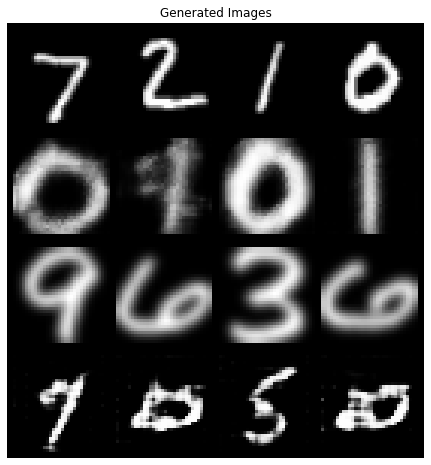

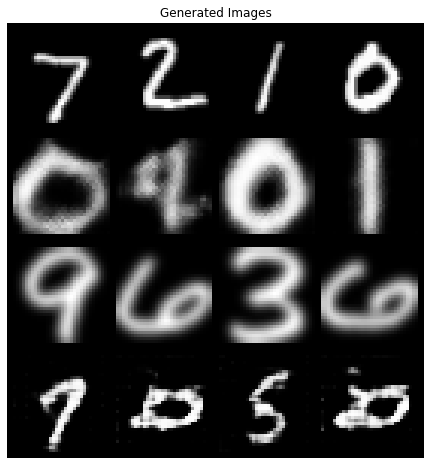

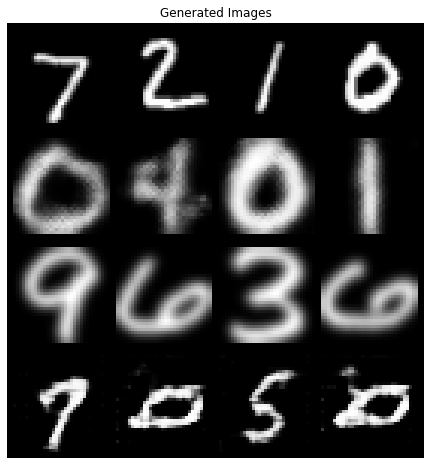

KeyboardInterrupt: ignored

In [ ]:
D_X_losses, D_Y_losses = [], []
G_XY_losses, G_YX_losses = [], []

total_it = 0
for epoch in range(n_epochs):
    for i, batch in enumerate(train_dataloader):
        # Sample (x1, ..., xm) from p_X
        real_X = Variable(batch['X'].type(Tensor))
        # Sample (y1, ..., ym) from p_Y
        real_Y = Variable(batch['Y'].type(Tensor))

        # Generate fake images from Y to X: (G_YX(y1), ..., G_YX(ym))
        gen_X = G_YX(real_Y)
        # Generate fake images from X to Y: (G_XY(x1), ..., G_XY(xm))
        gen_Y = G_XY(real_X)

        # Update the discriminators D_X and D_Y
        optimizer_D_X.zero_grad()
        optimizer_D_Y.zero_grad()
        # Compute D_X loss
        #D_X_loss = MSE_loss(D_X(real_X), 1.) + MSE_loss(D_X(gen_X.detach()), 0.)
        D_X_loss = torch.mean((D_X(real_X) - 1.) ** 2) + torch.mean((D_X(gen_X.detach()) - 0.) ** 2)
        # Compute D_Y loss
        #D_X_loss = MSE_loss(D_Y(real_Y), 1.) + MSE_loss(D_Y(gen_Y.detach()), 0.)
        D_Y_loss = torch.mean((D_Y(real_Y) - 1.) ** 2) + torch.mean((D_Y(gen_Y.detach()) - 0.) ** 2)
        # Update the parameters of the discriminators D_X and D_Y
        D_X_loss.backward()
        D_Y_loss.backward()
        optimizer_D_X.step()
        optimizer_D_Y.step()

        # Update the generators G_XY and G_YX
        optimizer_G_XY.zero_grad()
        optimizer_G_YX.zero_grad()
        # Compute G_XY loss
        G_XY_loss = torch.mean((D_Y(gen_Y) - 1.) ** 2) + lambda_cycle * torch.mean(torch.abs(G_XY(gen_X) - real_Y))
        # Compute G_YX loss
        G_YX_loss = torch.mean((D_X(gen_X) - 1.) ** 2) + lambda_cycle * torch.mean(torch.abs(G_YX(gen_Y) - real_X))
        # Compute full loss
        full_loss = G_XY_loss + G_YX_loss
        # Update the parameters of the generators G_XY and G_YX
        full_loss.backward()
        optimizer_G_XY.step()
        optimizer_G_YX.step()

        D_X_losses.append(D_X_loss.item())
        D_Y_losses.append(D_Y_loss.item())
        G_XY_losses.append(G_XY_loss.item())
        G_YX_losses.append(G_YX_loss.item())

        total_it += 1

    if epoch % 50 == 0:
        sample_images()

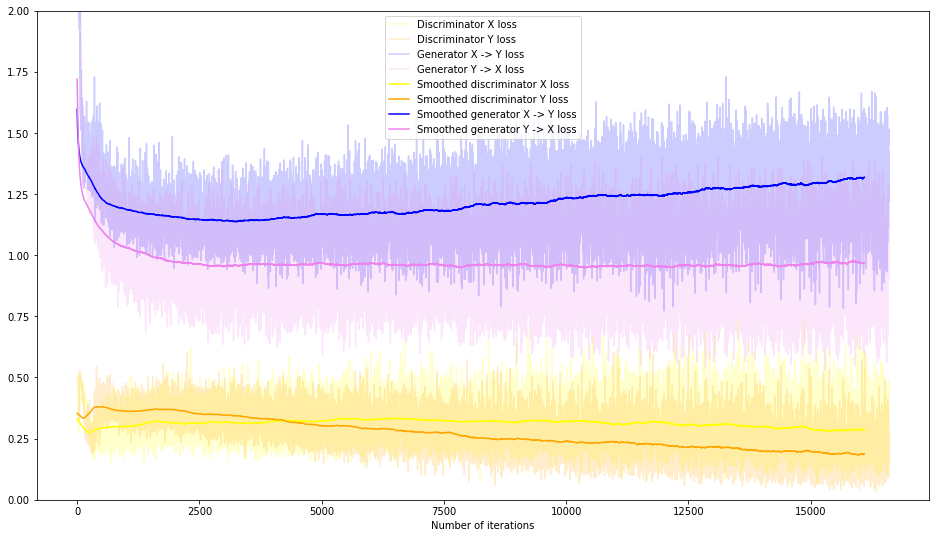

In [ ]:
window_width = 500

def apply_smoothing(loss):
    tmp = np.cumsum(loss)
    smooth_loss = (tmp[window_width:] - tmp[:-window_width]) / window_width
    return smooth_loss

smooth_D_X_losses = apply_smoothing(D_X_losses)
smooth_D_Y_losses = apply_smoothing(D_Y_losses)
smooth_G_XY_losses = apply_smoothing(G_XY_losses)
smooth_G_YX_losses = apply_smoothing(G_YX_losses)

plt.figure(figsize=(16, 9))

plt.plot(D_X_losses, label='Discriminator X loss', alpha=.2, c='yellow')
plt.plot(D_Y_losses, label='Discriminator Y loss', alpha=.2, c='orange')
plt.plot(G_XY_losses, label='Generator X -> Y loss', alpha=.2, c='blue')
plt.plot(G_YX_losses, label='Generator Y -> X loss', alpha=.2, c='violet')

plt.plot(smooth_D_X_losses, label='Smoothed discriminator X loss', alpha=1., c='yellow')
plt.plot(smooth_D_Y_losses, label='Smoothed discriminator Y loss', alpha=1., c='orange')
plt.plot(smooth_G_XY_losses, label='Smoothed generator X -> Y loss', alpha=1., c='blue')
plt.plot(smooth_G_YX_losses, label='Smoothed generator Y -> X loss', alpha=1., c='violet')

plt.ylim(0, 2)
plt.xlabel('Number of iterations')
plt.legend()
plt.show()